# **Capstone Project - IBM Professional Certificate in Data Science - Coursera**

# Montréal's Neighborhoods Analysis - Where to open a wellness facility?
## By Antoine Morin

The goal of this notebook is to determine, based on the data available for each neighborhood of the city of Montréal, which neighborhood would be better suited to invest in the opening of a new wellness facility, for example a gym or a yoga studio. To do this, I have identified the following 5 necessary steps:
1. Data Collection
2. Data Understanding
3. Data Preparation
4. Modeling
5. Evaluation

Note that a report containing more details about the methodology and the findings is also available in the Github repository of this project.

### **Step 0: Importing the librairies**

In [1]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from bs4 import BeautifulSoup
import requests
from geopy.geocoders import Nominatim
import folium
import json
from pandas.io.json import json_normalize
from scipy import stats
from sklearn.linear_model import LinearRegression
%matplotlib inline

### **Step 1: Data Collection**

For this step, we first use **BeautifulSoup** to extract the postal codes of Montréal and the name of the neighborhoods from a Wikipedia page and put them in a DataFrame df.

In [2]:
url = "https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_H"
headers = {"User-Agent":"Mozilla/5.0 (Windows NT 10.0; Win64; x64; rv:84.0) Gecko/20100101 Firefox/84.0"}
response = requests.get(url, headers=headers)
content = response.content
soup = BeautifulSoup(content)
table = soup.find('table', attrs={'rules':'all'})
codes = []
for row in table.findAll('tr'):
    for col in row.findAll('td'):
        code = []
        # Get the postal code
        postal = col.find('b')
        code.append(postal.text)
        # Get the name. Sometimes there is a cardinal direction and sometimes not. We try to include it:
        if (col.find('a') is not None):
            fullname = col.find('span').text
            reducedname = col.find('a').text
            if (fullname != reducedname):
                name = reducedname + " " + fullname[len(reducedname):]
            else:
                name = fullname
        else:
            name = col.find('span').text
        code.append(name)
        codes.append(code)
col_names = ['PostalCode','Neighborhood']
df = pd.DataFrame(codes, columns=col_names)
df.replace('Not assigned',np.nan,inplace=True)
df.dropna(axis=0,subset=['Neighborhood'],inplace=True)
df.reset_index(drop=True,inplace=True)
df.head()

,PostalCode,Neighborhood
0,H1A,Pointe-aux-Trembles
1,H2A,"Saint-Michel ,East"
2,H3A,Downtown Montreal North(McGill University)
3,H4A,Notre-Dame-de-Grâce Northeast
4,H5A,Place Bonaventure


We then drop the postal codes that are in Laval (number equal to 7), i.e. NOT in Montréal.

In [3]:
Mtl = []
for idx in range(len(df)):
    if (int(df['PostalCode'][idx][1]) == 7):
        Mtl.append(False)
    else:
        Mtl.append(True)
df_mtl = df[Mtl]
print("Our initial Dataframe had {} postal codes, now it has {}.".format(df.shape,df_mtl.shape))
print("Thus, there were initially {} neighborhoods that were in fact in Laval.".format(len(df)-len(df_mtl)))

Our initial Dataframe had (124, 2) postal codes, now it has (105, 2).
Thus, there were initially 19 neighborhoods that were in fact in Laval.


We will now represent all the neighborhoods on a map. First, we need the latitude and longitude of Montréal.

In [4]:
address = 'Montreal, Quebec'
geolocator = Nominatim(user_agent="montreal_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print("The latitude of Montréal is {} and its longitude is {}".format(latitude, longitude))

The latitude of Montréal is 45.4972159 and its longitude is -73.6103642


Because Nominatim doesn't seem to work when trying to get the latitudes and longitudes of every neighborhood based on their postal codes, I have done it by hand using Google Maps. We will import the cleaned DataFrame containing the latitudes and the longitudes.

In [5]:
df_cleaned = pd.read_csv('PostalCodesMtlLatLng.csv')
df_cleaned.head()

,PostalCode,Neighborhood,Latitude,Longitude
0,H1A,Pointe-aux-Trembles,45.67706,-73.50252
1,H2A,Saint-Michel Est,45.56157,-73.59912
2,H3A,Downtown Montréal Nord,45.50435,-73.57668
3,H4A,Notre-Dame-de-Grâce Nord-Ouest,45.47271,-73.61494
4,H5A,Place Bonaventure,45.49970,-73.56570


We can then represent every neighborhood on a map.

In [6]:
map_montreal = folium.Map(location=[latitude, longitude], zoom_start=10)

# Add markers to map
for lat, lng, neighborhood in zip(df_cleaned['Latitude'], df_cleaned['Longitude'], df_cleaned['Neighborhood']):
    label = '{}'.format(neighborhood)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='blue',
        fill_opacity=0.7,
        parse_html=False).add_to(map_montreal)  
    
map_montreal

The next step for Data Collection is to get a list a venues for each neighborhood using the **FourSquare API**. Before doing so, we will estimate the mean distance between each neighborhood and use this knowledge to pass a reasonable **radius** arugment in the API call. 

In [7]:
# Let's assume the Earth is a perfect sphere of radius R = 6367449 m
R = 6367449
dist_nearest = []
for idx in range(len(df_cleaned)):
    init_pt = np.pi*np.array([df_cleaned.loc[idx,'Latitude'],df_cleaned.loc[idx,'Longitude']])/180.0
    other_pts = np.pi*np.array(df_cleaned.drop(idx)[['Latitude','Longitude']])/180.0
    del_lat = other_pts[:,0]-init_pt[0]
    del_lng = other_pts[:,1]-init_pt[1]
    # By the law of cosines:
    theta = np.arccos(np.cos(del_lat)+np.cos(del_lng)-1)
    distances = theta*R
    dist_nearest.append(np.min(distances))
print('The minimum distance is {} meters, the maximum distance is {} meters, and the mean distance is {} meters.'.format(int(np.round(np.min(dist_nearest))),int(np.round(np.max(dist_nearest))),int(np.round(np.mean(dist_nearest)))))

The minimum distance is 349 meters, the maximum distance is 4427 meters, and the mean distance is 1940 meters.


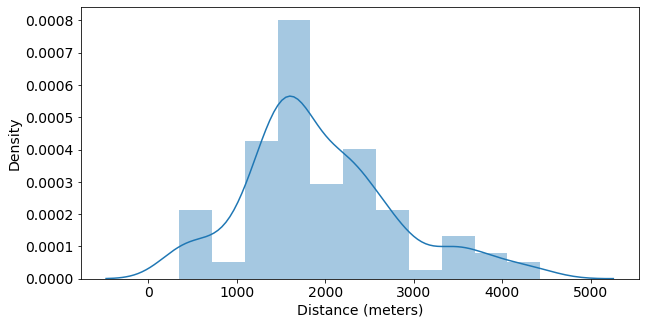

In [8]:
# Let's see the distribution of the distances
fig = plt.figure(figsize=(10,5))
ax0 = fig.add_subplot(1,1,1)
sns.distplot(dist_nearest,ax=ax0)
plt.xlabel('Distance (meters)',fontsize=14)
plt.ylabel('Density',fontsize=14)
ax0.tick_params(labelsize=14)
plt.show()

Based on the previous analysis, we will look at venues in each neighborhood inside a cercle of radius 1000 meters to avoid overlap and at the same time to cover most of the city. We will now use the **FourSquare API** to get the venues.

In [9]:
# Credentials and parameters
CLIENT_ID = 'your-client-id'
CLIENT_SECRET = 'your-client-secret'
VERSION = '20180605'
LIMIT = 100

In [10]:
# Function to get nearby venues
def getNearbyVenues(names, latitudes, longitudes, radius=1000):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [11]:
montreal_venues = getNearbyVenues(names=df_cleaned['Neighborhood'],
                                   latitudes=df_cleaned['Latitude'],
                                   longitudes=df_cleaned['Longitude']
                                  )
montreal_venues.head()

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Pointe-aux-Trembles,45.67706,-73.50252,Parc-nature de la Pointe-aux-Prairies,45.678834,-73.501162,Park
1,Pointe-aux-Trembles,45.67706,-73.50252,Dépanneur Mario,45.671119,-73.496001,Convenience Store
2,Pointe-aux-Trembles,45.67706,-73.50252,Metro Plus De La Rousselière,45.669364,-73.506622,Supermarket
3,Pointe-aux-Trembles,45.67706,-73.50252,Proxim,45.668749,-73.499512,Pharmacy
4,Saint-Michel Est,45.56157,-73.59912,Marché Aux Puces Saint-Michel,45.562502,-73.605079,Flea Market


We now have all the necessary data for the project and this concludes the first step.

### **Step 2: Data Understanding**

Let's start by looking at the number of venues returned by the API for each neighborhood. To get a quick look at all the numbers, we will simply display them as an array.

In [12]:
# Note: To ensure reproducibility of this work, we will work with the venues stored in the csv file montreal_venues.
montreal_venues = pd.read_csv('montreal_venues.csv')

In [13]:
mtl_grouped = montreal_venues.groupby('Neighborhood').count()
mtl_grouped['Venue'].values

array([ 49,  19,  25,  67,  30,  12,   6,   5,  26,  22,   5,  65, 100,
        26,  13,  39,  52,  73,  67,  68,   4,  37,   6,  41, 100, 100,
        57, 100,  14, 100,  33,  68,   6,   5,   2,  29,  36,  13,  12,
         6,  61,  17,  24,   9,   5,  11,  19,  19,  25,  48,  40, 100,
        46, 100,  34,  40,  86, 100,   5,   6, 100, 100, 100, 100, 100,
       100, 100,  17,  40,   4,   5,  10,  33,  13,  64,  34,  13,   9,
        33,  47,  13,   5,  11,  11,  30,  28,   7,   5,  15,   2, 100,
        65,  13, 100,  22,  27,  50,  72, 100,  27,  86], dtype=int64)

In [14]:
print("The mean number of venues returned is {}.".format(np.mean(mtl_grouped['Venue'].values)))

The mean number of venues returned is 41.02970297029703.


From this, we clearly see that some neighborhoods have a small number of venues. Further down the road, we will focus on neighborhoods will a large number of venues. Now, let's look at the different categories of venues.

In [15]:
venues_cat = montreal_venues[['Venue Category','Venue']]
venues_grouped = venues_cat.groupby('Venue Category').count()
venues_grouped.reset_index(inplace=True)
print(np.array(venues_grouped))

[['ATM' 4]
 ['Adult Boutique' 1]
 ['Afghan Restaurant' 2]
 ['Airport' 2]
 ['Airport Lounge' 4]
 ['Airport Service' 3]
 ['American Restaurant' 9]
 ['Arcade' 1]
 ['Arepa Restaurant' 3]
 ['Argentinian Restaurant' 1]
 ['Art Gallery' 15]
 ['Art Museum' 14]
 ['Arts & Crafts Store' 6]
 ['Arts & Entertainment' 3]
 ['Asian Restaurant' 35]
 ['Athletics & Sports' 11]
 ['Australian Restaurant' 2]
 ['Auto Dealership' 2]
 ['Auto Garage' 1]
 ['Automotive Shop' 4]
 ['BBQ Joint' 15]
 ['Bagel Shop' 8]
 ['Bakery' 124]
 ['Bank' 43]
 ['Bar' 56]
 ['Baseball Field' 6]
 ['Beach' 2]
 ['Bed & Breakfast' 4]
 ['Beer Bar' 15]
 ['Beer Garden' 1]
 ['Beer Store' 11]
 ['Big Box Store' 4]
 ['Bike Rental / Bike Share' 6]
 ['Bike Shop' 2]
 ['Bistro' 19]
 ['Boat or Ferry' 1]
 ['Bookstore' 31]
 ['Botanical Garden' 1]
 ['Boutique' 23]
 ['Bowling Alley' 4]
 ['Boxing Gym' 2]
 ['Breakfast Spot' 67]
 ['Brewery' 23]
 ['Buffet' 2]
 ['Building' 1]
 ['Burger Joint' 20]
 ['Burrito Place' 5]
 ['Bus Line' 4]
 ['Bus Station' 8]
 ['Bus 

From this, we will define the following general categories:

In [16]:
Restaurants = ["Afghan Restaurant","American Restaurant","Arepa Restaurant","Argentinian Restaurant","Asian Restaurant","Australian Restaurant","Cajun / Creole Restaurant","Cambodian Restaurant","Caribbean Restaurant","Chinese Restaurant","Comfort Food Restaurant","Dumpling Restaurant","Eastern European Restaurant","Empanada Restaurant","English Restaurant","Falafel Restaurant","Filipino Restaurant","French Restaurant","German Restaurant","Greek Restaurant","Hawaiian Restaurant","Indian Restaurant","Indonesian Restaurant","Italian Restaurant","Japanese Restaurant","Jewish Restaurant","Korean Restaurant","Latin American Restaurant","Lebanese Restaurant","Mediterranean Restaurant","Mexican Restaurant","Middle Eastern Restaurant","Modern European Restaurant","Moroccan Restaurant","New American Restaurant","North Indian Restaurant","Persian Restaurant","Peruvian Restaurant","Polish Restaurant","Portuguese Restaurant","Ramen Restaurant","Restaurant","Russian Restaurant","Salvadoran Restaurant","Seafood Restaurant","South American Restaurant","Spanish Restaurant","Sri Lanka Restaurant","Steakhouse","Sushi Restaurant","Swiss Restaurant","Szechuan Restaurant","Tapas Restaurant","Tex-Mex Restaurant","Thai Restaurant","Tibetan Restaurant","Turkish Restaurant","Vegetarian / Vegan Restaurant","Vietnamese Restaurant"]
Arts = ["Art Gallery","Art Museum","Arts & Crafts Store","Arts & Entertainment","Bookstore","Botanical Garden","College Bookstore","Comedy Club","Concert Hall","Garden","Garden Center","General Entertainment","Historic Site","History Museum","Indie Movie Theater","Jazz Club","Movie Theater","Museum","Music Store","Music Venue","Opera House","Performing Arts Venue","Planetarium","Public Art","Recording Studio","Theater","Video Store"]
Wellness = ["Athletics & Sports","Boxing Gym","Climbing Gym","College Gym","Dance Studio","Gym","Gym / Fitness Center","Gym Pool","Martial Arts School","Massage Studio","Spa","Sports Club","Yoga Studio"]
FastFood = ["BBQ Joint","Burger Joint","Burrito Place","Fast Food Restaurant","Fish & Chips Shop","Food Truck","Fried Chicken Joint","Hot Dog Joint","Mac & Cheese Joint","Pizza Place","Poutine Place","Sandwich Place","Taco Place"]
ArtisanalFood = ["Bagel Shop","Bakery","Breakfast Spot","Chocolate Shop","Creperie","Cupcake Shop","Dessert Shop","Donut Shop","Gourmet Shop","Ice Cream Shop","Juice Bar","Pastry Shop","Pie Shop","Sausage Shop"]
Bar = ["Bar","Beer Bar","Bistro","Brewery","Cocktail Bar","Dive Bar","Gastropub","Gay Bar","Hookah Bar","Irish Pub","Karaoke Bar","Lounge","Nightclub","Pub","Smoke Shop","Speakeasy","Sports Bar","Whisky Bar","Wine Bar"]
Cafe = ["Café","Coffee Shop","Gaming Cafe"]
PublicArea = ["Baseball Field","Beach","Canal","Cemetery","Church","Dog Run","Event Space","Football Stadium","Hockey Arena","Lake","Monument / Landmark","Mountain","Nature Preserve","Park","Playground","Plaza","Pool","Scenic Lookout","Soccer Field","Soccer Stadium","Stadium","Tennis Court","Tennis Stadium","Trail","Zoo"]
Essentials = ["Auto Garage","Auto Shop","Bank","Clothing Store","Convenience Store","Deli / Bodega","Drugstore","Electronics Store","Farmers Market","Fish Market","Flea Market","Food & Drink Shop","Fruit & Vegetable Store","Furniture / Home Store","Gas Station","Grocery Store","Hardware Store","Liquor Store","Market","Paper / Office Supplies Store","Pharmacy","Shopping Mall","Shopping Plaza","Supermarket"]

We are ready to prepare the data.

### **Step 3: Data Preparation**

We start by counting the number of venues that fall in each general categories for each neighborhood.

In [17]:
col_names = ['Neighborhood','Restaurants Count','Arts Count','Wellness Count','FastFood Count','ArtisanalFood Count','Bar Count','Cafe Count','PublicArea Count','Essentials Count']
df_count = pd.DataFrame(columns=col_names)
for neighborhood in df_cleaned['Neighborhood']:
    # Initialize all the counts
    count_Restaurants = 0
    count_Arts = 0
    count_Wellness = 0
    count_FastFood = 0
    count_ArtisanalFood = 0
    count_Bar = 0
    count_Cafe = 0
    count_PublicArea = 0
    count_Essentials = 0
    for venue_cat in montreal_venues[montreal_venues['Neighborhood']==neighborhood]['Venue Category']:
        count_Restaurants += (venue_cat in Restaurants)
        count_Arts += (venue_cat in Arts)
        count_Wellness += (venue_cat in Wellness)
        count_FastFood += (venue_cat in FastFood)
        count_ArtisanalFood += (venue_cat in ArtisanalFood)
        count_Bar += (venue_cat in Bar)
        count_Cafe += (venue_cat in Cafe)
        count_PublicArea += (venue_cat in PublicArea)
        count_Essentials += (venue_cat in Essentials)
    df_count = df_count.append({'Neighborhood':neighborhood,'Restaurants Count':count_Restaurants,'Arts Count':count_Arts,'Wellness Count':count_Wellness,'FastFood Count':count_FastFood,'ArtisanalFood Count':count_ArtisanalFood,'Bar Count':count_Bar,'Cafe Count':count_Cafe,'PublicArea Count':count_PublicArea,'Essentials Count':count_Essentials},ignore_index=True)
df_count.head()

,Neighborhood,Restaurants Count,Arts Count,Wellness Count,FastFood Count,ArtisanalFood Count,Bar Count,Cafe Count,PublicArea Count,Essentials Count
0,Pointe-aux-Trembles,0,0,0,0,0,0,0,1,3
1,Saint-Michel Est,9,0,0,3,1,1,1,0,12
2,Downtown Montréal Nord,14,13,3,8,4,7,12,10,7
3,Notre-Dame-de-Grâce Nord-Ouest,30,0,3,14,10,4,10,2,21
4,Place Bonaventure,24,6,4,9,3,5,14,9,6


We can add the total number of venues for each neighborhood.

In [18]:
df_count.insert(len(df_count.columns),'Total Counts',df_count.drop(['Neighborhood'],axis=1).sum(axis=1))
df_count.head()

,Neighborhood,Restaurants Count,Arts Count,Wellness Count,FastFood Count,ArtisanalFood Count,Bar Count,Cafe Count,PublicArea Count,Essentials Count,Total Counts
0,Pointe-aux-Trembles,0,0,0,0,0,0,0,1,3,4.0
1,Saint-Michel Est,9,0,0,3,1,1,1,0,12,27.0
2,Downtown Montréal Nord,14,13,3,8,4,7,12,10,7,78.0
3,Notre-Dame-de-Grâce Nord-Ouest,30,0,3,14,10,4,10,2,21,94.0
4,Place Bonaventure,24,6,4,9,3,5,14,9,6,80.0


As we said in the Data Understandind step, we will drop neighborhoods that have a low count of venues. We will only select the neighborhoods that have at least 50 venues. This parameter could eventually be improved.

In [19]:
nb_neigh_before = df_count.shape[0]
df_count = df_count[df_count['Total Counts'] >= 50]
df_count.reset_index(drop=True,inplace=True)
df_count.head()

,Neighborhood,Restaurants Count,Arts Count,Wellness Count,FastFood Count,ArtisanalFood Count,Bar Count,Cafe Count,PublicArea Count,Essentials Count,Total Counts
0,Downtown Montréal Nord,14,13,3,8,4,7,12,10,7,78.0
1,Notre-Dame-de-Grâce Nord-Ouest,30,0,3,14,10,4,10,2,21,94.0
2,Place Bonaventure,24,6,4,9,3,5,14,9,6,80.0
3,Downtown Montréal Est,21,8,3,9,3,3,18,8,5,78.0
4,Place Desjardins,22,11,2,6,5,19,10,7,4,86.0


In [20]:
print("We went from {} neighborhoods to {} neighborhoods.".format(nb_neigh_before,df_count.shape[0]))

We went from 101 neighborhoods to 31 neighborhoods.


If we want to compare the neighborhoods against each other, we need to normalize each row.

In [26]:
df_norm = df_count.loc[:,'Restaurants Count':'Essentials Count']/df_count[['Total Counts']].values
df_norm.insert(0,'Neighborhood',df_count['Neighborhood'])
df_norm.head()

,Neighborhood,Restaurants Count,Arts Count,Wellness Count,FastFood Count,ArtisanalFood Count,Bar Count,Cafe Count,PublicArea Count,Essentials Count
0,Downtown Montréal Nord,0.179487,0.166667,0.0384615,0.102564,0.0512821,0.0897436,0.153846,0.128205,0.0897436
1,Notre-Dame-de-Grâce Nord-Ouest,0.319149,0,0.0319149,0.148936,0.106383,0.0425532,0.106383,0.0212766,0.223404
2,Place Bonaventure,0.3,0.075,0.05,0.1125,0.0375,0.0625,0.175,0.1125,0.075
3,Downtown Montréal Est,0.269231,0.102564,0.0384615,0.115385,0.0384615,0.0384615,0.230769,0.102564,0.0641026
4,Place Desjardins,0.255814,0.127907,0.0232558,0.0697674,0.0581395,0.22093,0.116279,0.0813953,0.0465116


In [27]:
print('The principal neighborhoods are composed, in general, of {}% restaurants, {}% arts activites, {}% wellness facilities,\n {}% fast food, {}% artisanal food shop, {}% bars, {}% cafés, {}% public area, and {}% essentials shops.'.format(np.round(100*np.mean(df_norm['Restaurants Count']),1),np.round(100*np.mean(df_norm['Arts Count']),1),np.round(100*np.mean(df_norm['Wellness Count']),1),np.round(100*np.mean(df_norm['FastFood Count']),1),np.round(100*np.mean(df_norm['ArtisanalFood Count']),1),np.round(100*np.mean(df_norm['Bar Count']),1),np.round(100*np.mean(df_norm['Cafe Count']),1),np.round(100*np.mean(df_norm['PublicArea Count']),1),np.round(100*np.mean(df_norm['Essentials Count']),1)))
print('The neighborhood with the least wellness facilities is {} with a percentage of {}%.'.format(df_norm['Neighborhood'][df_norm['Wellness Count'].values.argmin()],np.round(100*df_norm['Wellness Count'].values.min(),2)))
print('The neighborhood with the most wellness facilities is {} with a percentage of {}%.'.format(df_norm['Neighborhood'][df_norm['Wellness Count'].values.argmax()],np.round(100*df_norm['Wellness Count'].values.max(),2)))

The principal neighborhoods are composed, in general, of 27.1% restaurants, 7.1% arts activites, 4.7% wellness facilities,
 9.7% fast food, 10.0% artisanal food shop, 9.0% bars, 12.7% cafés, 6.4% public area, and 13.4% essentials shops.
The neighborhood with the least wellness facilities is Outremont with a percentage of 1.1%.
The neighborhood with the most wellness facilities is Maisonneuve with a percentage of 11.32%.


### **Step 4: Modeling**

We will start by looking for any correlations amongst the data, regarding the wellness category. This will allow us to select the best categories to implement a **Multiple Linear Regression** using **Scikit-Learn**.

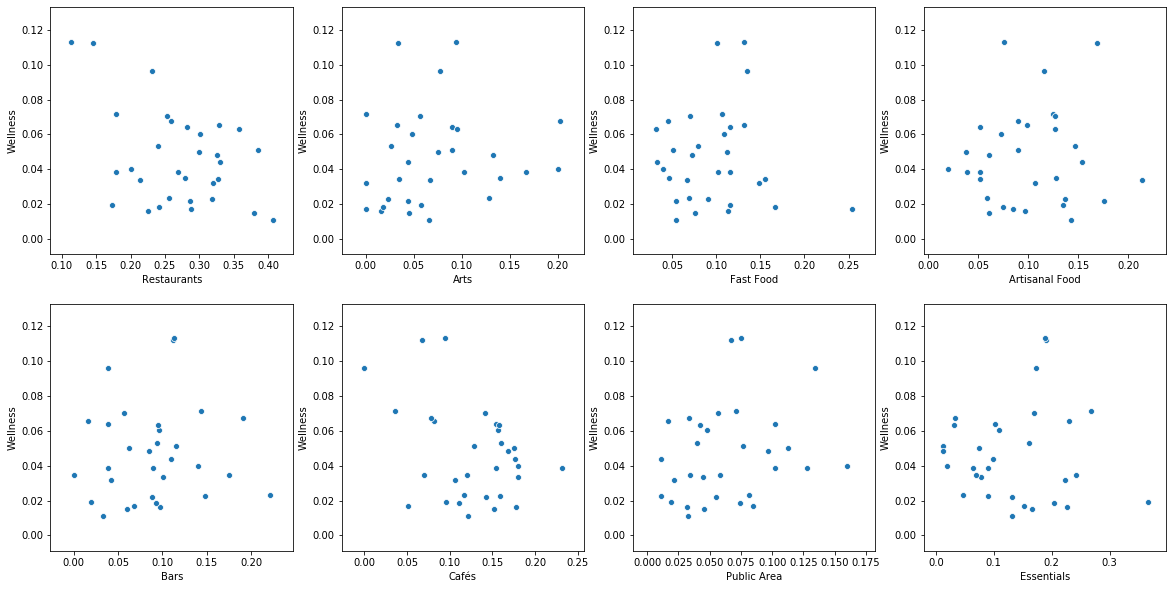

In [28]:
# Let's start by visualizing the data with scatter plots
fig = plt.figure(figsize=(20,10))
ax0 = fig.add_subplot(2,4,1)
ax1 = fig.add_subplot(2,4,2)
ax2 = fig.add_subplot(2,4,3)
ax3 = fig.add_subplot(2,4,4)
ax4 = fig.add_subplot(2,4,5)
ax5 = fig.add_subplot(2,4,6)
ax6 = fig.add_subplot(2,4,7)
ax7 = fig.add_subplot(2,4,8)

# Subplot 1: Wellness vs Restaurants
sns.scatterplot(x="Restaurants Count",y="Wellness Count",data=df_norm,ax=ax0)
ax0.set_xlabel("Restaurants")
ax0.set_ylabel("Wellness")

# Subplot 2: Wellness vs Arts
sns.scatterplot(x="Arts Count",y="Wellness Count",data=df_norm,ax=ax1)
ax1.set_xlabel("Arts")
ax1.set_ylabel("Wellness")

# Subplot 3: Wellness vs FastFood
sns.scatterplot(x="FastFood Count",y="Wellness Count",data=df_norm,ax=ax2)
ax2.set_xlabel("Fast Food")
ax2.set_ylabel("Wellness")

# Subplot 4: Wellness vs ArtisanalFood
sns.scatterplot(x="ArtisanalFood Count",y="Wellness Count",data=df_norm,ax=ax3)
ax3.set_xlabel("Artisanal Food")
ax3.set_ylabel("Wellness")

# Subplot 5: Wellness vs Bar
sns.scatterplot(x="Bar Count",y="Wellness Count",data=df_norm,ax=ax4)
ax4.set_xlabel("Bars")
ax4.set_ylabel("Wellness")

# Subplot 6: Wellness vs Cafe
sns.scatterplot(x="Cafe Count",y="Wellness Count",data=df_norm,ax=ax5)
ax5.set_xlabel("Cafés")
ax5.set_ylabel("Wellness")

# Subplot 7: Wellness vs PublicArea
sns.scatterplot(x="PublicArea Count",y="Wellness Count",data=df_norm,ax=ax6)
ax6.set_xlabel("Public Area")
ax6.set_ylabel("Wellness")

# Subplot 8: Wellness vs Essentials
sns.scatterplot(x="Essentials Count",y="Wellness Count",data=df_norm,ax=ax7)
ax7.set_xlabel("Essentials")
ax7.set_ylabel("Wellness")

plt.show()

It's hard to see some patterns from these plots. Let's check the Pearson Correlation Coefficients.

In [29]:
df_norm.set_index('Neighborhood',inplace=True)
df_norm=df_norm.apply(pd.to_numeric, errors='coerce')
corr = df_norm.corr()
corr

,Restaurants Count,Arts Count,Wellness Count,FastFood Count,ArtisanalFood Count,Bar Count,Cafe Count,PublicArea Count,Essentials Count
Restaurants Count,1.000000,-0.126829,-0.425009,-0.194801,-0.068082,-0.235426,0.240444,-0.323562,-0.326769
Arts Count,-0.126829,1.000000,0.125282,-0.507838,-0.392518,0.416680,0.167693,0.507125,-0.660875
Wellness Count,-0.425009,0.125282,1.000000,-0.026690,0.055972,0.060559,-0.363880,0.231423,0.014220
FastFood Count,-0.194801,-0.507838,-0.026690,1.000000,-0.267239,-0.443626,-0.369109,0.101552,0.529623
ArtisanalFood Count,-0.068082,-0.392518,0.055972,-0.267239,1.000000,0.067701,-0.197680,-0.554277,0.219907
Bar Count,-0.235426,0.416680,0.060559,-0.443626,0.067701,1.000000,-0.064823,0.069895,-0.482531
Cafe Count,0.240444,0.167693,-0.363880,-0.369109,-0.197680,-0.064823,1.000000,0.007830,-0.434938
PublicArea Count,-0.323562,0.507125,0.231423,0.101552,-0.554277,0.069895,0.007830,1.000000,-0.379356
Essentials Count,-0.326769,-0.660875,0.014220,0.529623,0.219907,-0.482531,-0.434938,-0.379356,1.000000


Let's visualize these numbers using a **heatmap** of the **correlation matrix**.

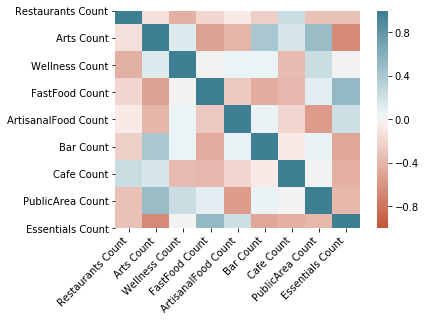

In [30]:
ax = sns.heatmap(
    corr, 
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True
)
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='right'
);

From this, we can see that the best correlations involving wellness concern restaurants, arts, cafés and public areas. Let's check the p-value for each one:

In [31]:
coef_restaurants, p_restaurants = stats.pearsonr(df_norm['Restaurants Count'],df_norm['Wellness Count'])
coef_arts, p_arts = stats.pearsonr(df_norm['Arts Count'],df_norm['Wellness Count'])
coef_cafes, p_cafes = stats.pearsonr(df_norm['Cafe Count'],df_norm['Wellness Count'])
coef_public, p_public = stats.pearsonr(df_norm['PublicArea Count'],df_norm['Wellness Count'])
print("The Pearson Correlation Coefficient between Restaurants and Wellness is {} with a P-value of {}".format(np.round(coef_restaurants,2),p_restaurants))
print("The Pearson Correlation Coefficient between Arts and Wellness is {} with a P-value of {}".format(np.round(coef_arts,2),p_arts))
print("The Pearson Correlation Coefficient between Cafés and Wellness is {} with a P-value of {}".format(np.round(coef_cafes,2),p_cafes))
print("The Pearson Correlation Coefficient between Public Areas and Wellness is {} with a P-value of {}".format(np.round(coef_public,2),p_public))

The Pearson Correlation Coefficient between Restaurants and Wellness is -0.43 with a P-value of 0.017155767184979555
The Pearson Correlation Coefficient between Arts and Wellness is 0.13 with a P-value of 0.5018819495559534
The Pearson Correlation Coefficient between Cafés and Wellness is -0.36 with a P-value of 0.044185686258411856
The Pearson Correlation Coefficient between Public Areas and Wellness is 0.23 with a P-value of 0.21033475614974814


From the above p-values, it seems that the only significant correlations involve Restaurants and Cafés. The p-values are respectively 0.017 and 0.044 (< 0.05), indicating a moderate evidence that the correlation is significant. The Pearson Correlation Coefficients are respectively -0.43 and -0.36, indicating a negative linear relationship between the number of restaurants and cafés and the number of wellness centers. In other words, we would expect more wellness centers in neighborhoods having less restaurants and cafés. Let's calculate this linear relationship.

In [32]:
X = df_norm[['Restaurants Count','Cafe Count']]
y = df_norm['Wellness Count']
lm = LinearRegression()
lm.fit(X,y)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

We can now evaluate the model and answer our initial question.

### **Step 5: Evaluation**

Instead of looking at the absolute errors or mean squared errors, as is usually done with most evaluation methods, we will look directly at the error given by y-yhat, where yhat is the predicted value by the model. This is important because we want to know where the error is negative, indicating that there should be more wellness centers (yhat) than observed (y). This can lead directly to a business opportunity. We will select the neighborhood having the largest negative error.

In [33]:
yhat = lm.predict(X)
error = y-yhat
print("The best neighborhood where to open a Wellness facility is {}.".format(error.index[error.values.argmin()]))

The best neighborhood where to open a Wellness facility is Ahuntsic Sud-Est.


Let's explore this particular neighborhood.

In [34]:
AhuntsicSE = montreal_venues[montreal_venues['Neighborhood']=='Ahuntsic Sud-Est']
AhuntsicSE.head()

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
2024,Ahuntsic Sud-Est,45.54077,-73.65015,Cafe Bar Gentile,45.538493,-73.654564,Italian Restaurant
2025,Ahuntsic Sud-Est,45.54077,-73.65015,Rudsak Atelier,45.543857,-73.649018,Clothing Store
2026,Ahuntsic Sud-Est,45.54077,-73.65015,Boulangerie Old Country,45.536835,-73.647397,Bakery
2027,Ahuntsic Sud-Est,45.54077,-73.65015,Poissonnerie Coralli,45.536257,-73.649668,Fish Market
2028,Ahuntsic Sud-Est,45.54077,-73.65015,L'Oeufrier,45.540178,-73.653662,Breakfast Spot


Which wellness facilities are already present there?

In [35]:
AhuntsicSE_grouped = AhuntsicSE[['Venue','Venue Category']].groupby('Venue Category').count()
AhuntsicSE_wellness = []
for wellness_cat in Wellness:
    if wellness_cat in AhuntsicSE_grouped.index:
        AhuntsicSE_wellness.append([wellness_cat,AhuntsicSE_grouped.loc[wellness_cat,'Venue']])
    else:
        AhuntsicSE_wellness.append([wellness_cat,0])
AhuntsicSE_wellness = pd.DataFrame(AhuntsicSE_wellness,columns = ['Wellness Facility','Count'])
AhuntsicSE_wellness

,Wellness Facility,Count
0,Athletics & Sports,0
1,Boxing Gym,0
2,Climbing Gym,0
3,College Gym,0
4,Dance Studio,0
5,Gym,0
6,Gym / Fitness Center,1
7,Gym Pool,0
8,Martial Arts School,0
9,Massage Studio,0


We see that there is only a Gym / Fitness Center in Ahuntsic Sud-Est. Maybe there could room to another Gym, to make some competition to the first one, or maybe we could open a Yoga Studio to complement the fitness center. Further steps could be to do a survey to the population living in this neighborhood. To end this analysis, let's map this neighborhood:

In [36]:
list_colors = len(df_cleaned)*['blue']
list_colors[df_cleaned[df_cleaned['Neighborhood']=='Ahuntsic Sud-Est'].index[0]] = 'red'
list_colors
map_montreal = folium.Map(location=[latitude, longitude], zoom_start=10)

# Add markers to map
for lat, lng, neighborhood, color in zip(df_cleaned['Latitude'], df_cleaned['Longitude'], df_cleaned['Neighborhood'], list_colors):
    label = '{}'.format(neighborhood)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color=color,
        fill=True,
        fill_color=color,
        fill_opacity=0.7,
        parse_html=False).add_to(map_montreal)  
    
map_montreal